In [140]:
import pandas as pd
import utils as ut
import numpy as np
from sgnn.model import GCN
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import pearsonr

df = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/acute_pre_processed/corr_matrices_gordon.csv')#.drop(columns='Unnamed: 0')
#HRS = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/Ayahuasca_HRS.csv')
# pcr = pd.read_csv('/Users/rodrigo/Documents/data/Ayahuasca/data/ayahuasca_acute_preacute/pcr_bdnf_cortisol_controles_aya_subacute.csv',  decimal=",")
# # Creating the 'Subject' and 'Group' columns by separating the number and the letter in 'subjectid'
# pcr['Subject'] = pcr['subjectid'].str.extract(r'(\d+)').astype(int)
# pcr['Group'] = pcr['subjectid'].str.extract(r'([A-Za-z]+)')
# pcr.rename(columns={'timepoint' : 'Time'}, inplace=True)
# pcr.drop(columns=['subjectid'], inplace=True)

N = 333


# # Inverting the condition to keep rows that do NOT match the condition
# df = df[~condition]

metrics = pd.DataFrame()

for g in ['Session_1', 'Session_2']:
        aux = df[(df.Group == g)]
        X_fmri = aux.select_dtypes(include=float).iloc[:,:-6]
        aux['STD'] = X_fmri.std(axis=1)
        aux['MEAN'] = X_fmri.mean(axis=1)

#         #aux = aux.join(X_fmri.apply(ut.calculate_properties, axis=1).apply(pd.Series))

        y = aux.reset_index().iloc[:,0]

        A = ut.reconstruct_symmetric_matrix(N, X_fmri.iloc[:,:].mean(axis=0))
        train_data, val_data = ut.create_graph(X_fmri, X_fmri, y, y,size=N, method={'knn_group' : ut.compute_KNN_graph(A, 15)})#, method={'threshold': 0.8})
        train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=1)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load model
        model = GCN(N, 3).to(device)
        model.load_state_dict(torch.load('/Users/rodrigo/Documents/data/Ayahuasca/data/subacute_pre_processed/model_params_333_TRUE.pth'))
        model.eval()

        y_pred_aux_age = []
        for y_i in val_loader:
            y_pred_aux_age.append((model(y_i))[1].detach().numpy().ravel()[0])

        aux['TEMP'] = y_pred_aux_age
        metrics = pd.concat([metrics, aux.loc[:, ['Group', 'Subject', 'MEAN', 'STD', 'TEMP', 'Translation_X', 'Translation_Y', 'Translation_Z', 
                        'Rotation_X', 'Rotation_Y', 'Rotation_Z']]])


metrics['TEMP'] = (metrics['TEMP']  - 2.23)


/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/2914801168.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['STD'] = X_fmri.std(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/2914801168.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['MEAN'] = X_fmri.mean(axis=1)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/2914801168.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which us

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ayahuasca, x='Subject', y='TEMP', palette=colors)


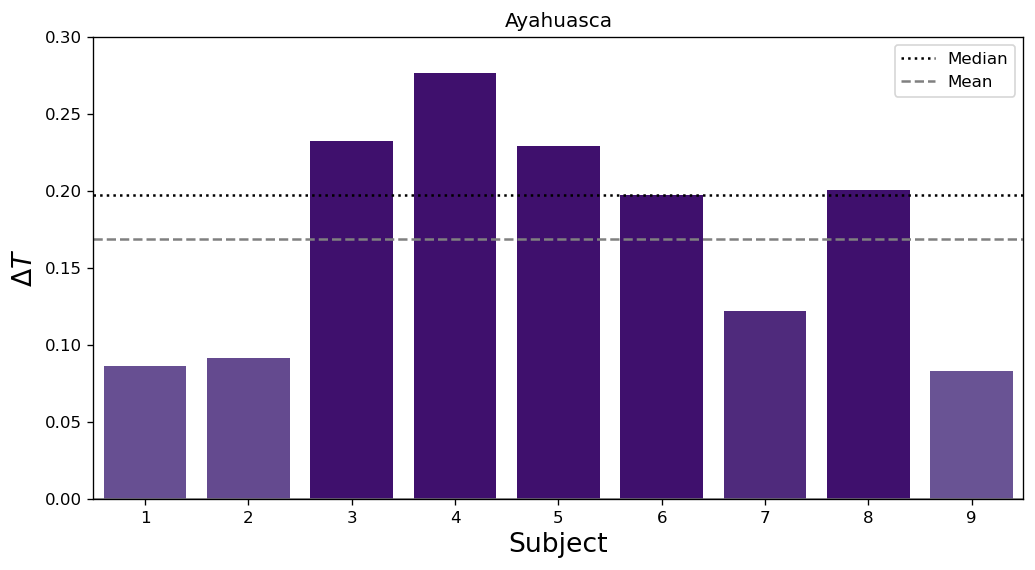

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='TEMP', palette=colors)


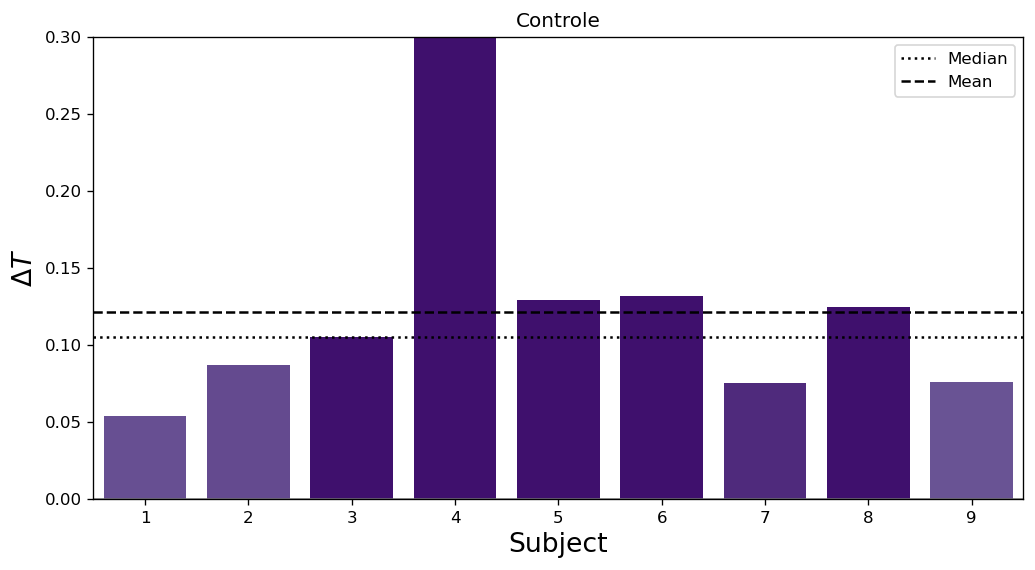

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(metrics, x='Group', y='TEMP',palette=colors)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)


TEMP T-TEST TtestResult(statistic=1.3478397859465725, pvalue=0.19648531243296039, df=16.0)


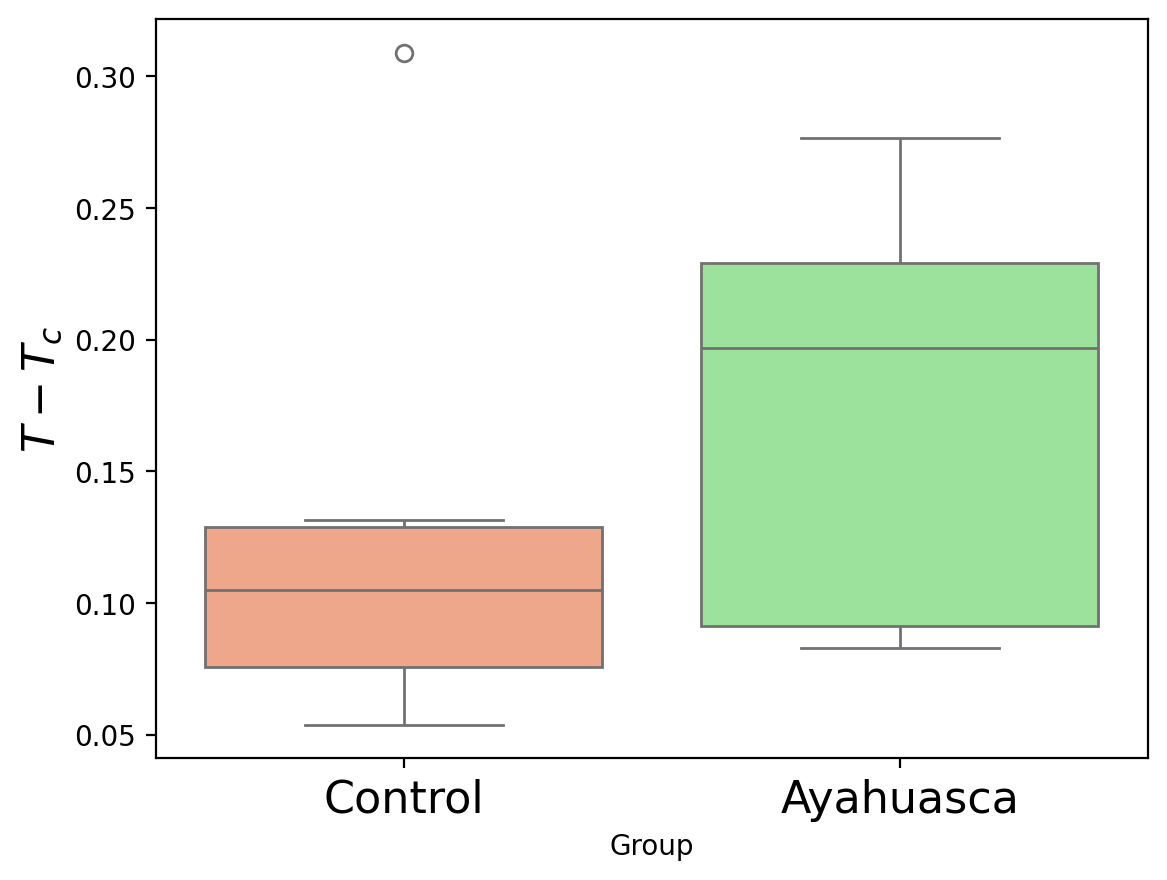

/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(result, y='TEMP',palette=colors)
/var/folders/jr/719jfw9158lghhhwj59_c2pm0000gn/T/ipykernel_21837/3757379924.py:72: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  g = sns.boxplot(result, y='TEMP',palette=colors)


Delta T T-TEST TtestResult(statistic=2.8213225874258208, pvalue=0.02244811257960236, df=8)


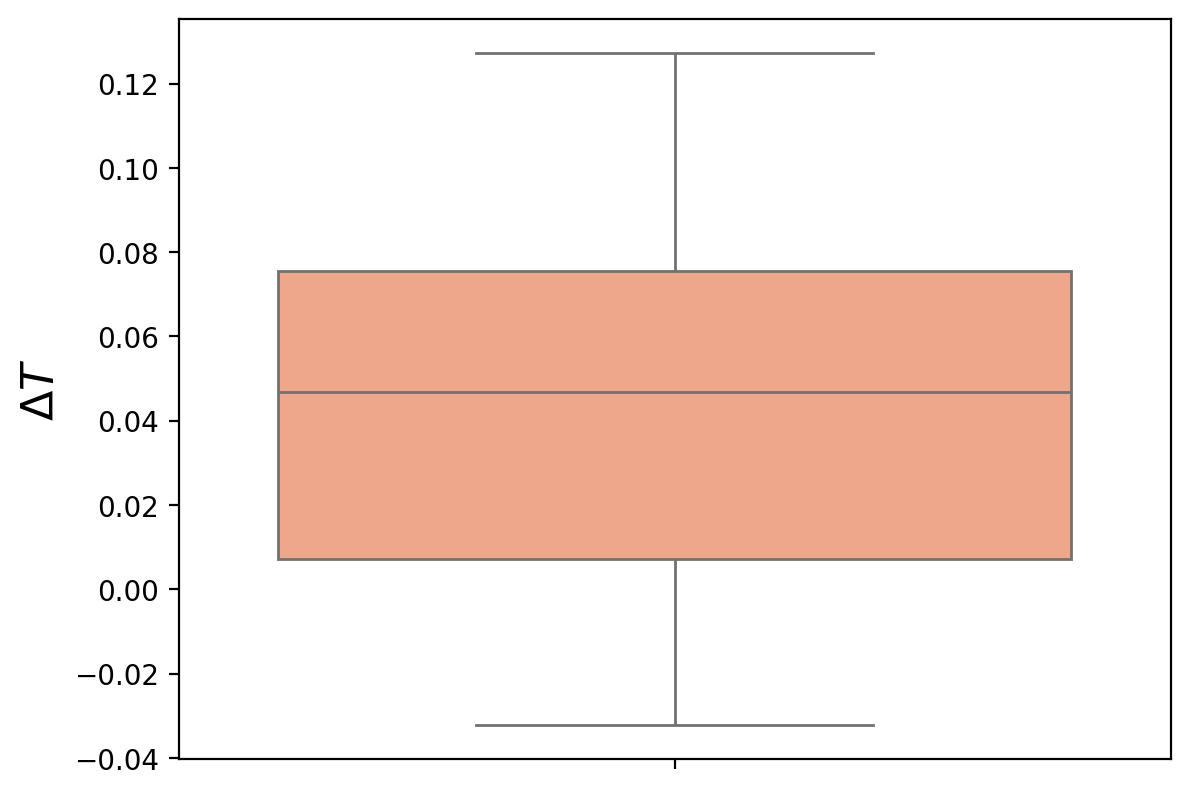

In [143]:
# Intra-subject
# Apply the function to each group using groupby
result = metrics[['Subject','MEAN','STD','TEMP']].groupby('Subject').diff().dropna()

group_o = metrics[metrics.Group == 'Session_1']
group_j = metrics[metrics.Group == 'Session_2']

from scipy import stats


ayahuasca = group_j[['Subject', 'TEMP']]
placebo = group_o[['Subject', 'TEMP']]

plt.figure(figsize=(10,5), dpi=120)
# Calculate the mean
mean_value = ayahuasca['TEMP'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(ayahuasca['Change'].min(), ayahuasca['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['TEMP']]

# Plotting
plt.title('Ayahuasca')
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=ayahuasca, x='Subject', y='TEMP', palette=colors)
plt.ylabel(r'$\Delta T$', fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=ayahuasca['TEMP'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='grey', linestyle='--', label='Mean')
plt.ylim(0,.3)
plt.legend()
plt.show()

plt.figure(figsize=(10,5), dpi=120)
plt.title('Controle')
# Calculate the mean
mean_value = placebo['TEMP'].mean()

# Normalize the values to create a gradient
#norm = plt.Normalize(placebo['Change'].min(), placebo['Change'].max())
norm = plt.Normalize(-.150, .150)
sm = plt.cm.ScalarMappable(cmap="Purples", norm=norm)
colors = [sm.to_rgba(val) for val in ayahuasca['TEMP']]
plt.axhline(y=0, color='grey', linestyle='-')
sns.barplot(data=pd.DataFrame(placebo).reset_index(), x='Subject', y='TEMP', palette=colors)
plt.ylabel(r'$\Delta T$', fontsize=16)
plt.xlabel('Subject', fontsize=16)
plt.axhline(y=placebo['TEMP'].median(), color='black', linestyle='dotted', label='Median')
plt.axhline(y=mean_value, color='black', linestyle='--', label='Mean')
plt.ylim(0,.3)
plt.legend()
plt.show()

colors = ['lightsalmon', 'lightgreen'] #['#808080', '#77dd77']

plt.figure(dpi=200)
# Display the resulting DataFrame
g = sns.boxplot(metrics, x='Group', y='TEMP',palette=colors)
#sns.swarmplot(result, x='Group', y='Change')
plt.ylabel(r'$ T - T_c$',  fontsize=16)
g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)
print('TEMP T-TEST', stats.ttest_ind(ayahuasca['TEMP'], placebo['TEMP']))

plt.show()

colors = ['lightsalmon', 'lightgreen'] #['#808080', '#77dd77']

plt.figure(dpi=200)
# Display the resulting DataFrame
g = sns.boxplot(result, y='TEMP',palette=colors)
#sns.swarmplot(result, x='Group', y='Change')
plt.ylabel(r'$ \Delta T$',  fontsize=16)
#g.set_xticklabels(['Control', 'Ayahuasca'],  fontsize=16)
print('Delta T T-TEST', stats.ttest_1samp(result['TEMP'], 0))


plt.show()


# plt.figure(dpi=200)

# ayahuasca = group_j[['Subject']]
# placebo = group_o[['Subject']]
# arr = [ayahuasca['TEMP'], placebo['TEMP']]
# # Perform t-test
# # Create a DataFrame for plotting
# data_to_plot = pd.DataFrame({'Placebo': placebo['TEMP'], 'Ayahuasca': ayahuasca['TEMP']})
# # Create the boxplot
# g = sns.boxplot(data=data_to_plot,palette=colors)
# # Set the x-tick labels
# g.set_xticks(range(len(arr)))
# g.set_xticklabels(['Placebo', 'Ayahuasca'],  fontsize=16)
# # Set y-label and y-limits
# plt.ylabel(r'$| T - T_c| $',  fontsize=16)
# #plt.ylim(2.20, 2.55)

# # Show the plot
# plt.show()
# print('After', stats.ttest_ind(ayahuasca['TEMP'], placebo['TEMP']))


In [137]:
result

,MEAN,STD,TEMP
9,0.068062,0.007121,0.032208
10,-0.029745,0.037608,0.004256
11,0.254732,-0.053650,0.127270
12,-0.060238,0.021832,-0.032154
13,0.162001,-0.028218,0.100137
14,0.111547,0.001853,0.065445
15,0.077267,0.028721,0.046765
16,0.128368,-0.017156,0.075629
17,0.026100,0.009389,0.007102


In [135]:
y = metrics['TEMP']
X = metrics[['Translation_X','Translation_Y', 'Translation_Z', 'Rotation_X', 'Rotation_Y', 'Rotation_Z']]

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

import statsmodels.api as sm

X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()
pred = mod.predict(X)

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   TEMP   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.141
Date:                Mon, 19 Aug 2024   Prob (F-statistic):              0.401
Time:                        12:22:45   Log-Likelihood:                 1.0365
No. Observations:                  18   AIC:                             11.93
Df Residuals:                      11   BIC:                             18.16
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1965      1.675      0.117

/Users/rodrigo/miniconda3/envs/ising_gnn/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)
